## Consituents and POS tags into a fully connected deep net
In this exploration we generate all the contituents for a set of training tweets then put the count of each one in a vector along with the count of tensed POS tags in a given tweet. We found that the POS tags alone outperform this model and it takes several hours to 

In [8]:
import sys
import pickle
import pandas

from nltk.parse.stanford import StanfordParser

def save_object(arr, filename):
    with open(filename, 'wb') as output:
        pickle.dump(arr, output, pickle.HIGHEST_PROTOCOL)

def add_to_train(constituents, row):
    trainData.append({
        'const': constituents, 
        'row': row,
        'tweet': row.Tweet, 
        'stance': row.Stance, 
        'target': row.Target
    })
    save_object(trainData, "train_0.txt")
    

def get_nodes(parent):
    for node in parent:
        if type(node) is nltk.Tree:
            if node.label() != ROOT:
                if node.label() not in constituentDictionary:
                    constituentDictionary[node.label()] = 1
                else:
                    constituentDictionary[node.label()] = constituentDictionary[node.label()] + 1
                # Keep global track of the constituents
                if node.label() not in globalConstDict:
                    globalConstDict[node.label()] = 1
                else:
                    globalConstDict[node.label()] = globalConstDict[node.label()] + 1
                    
            get_nodes(node)


def create_training_data(input_file, output_file):
    # Change the path according to your system
    stanford_classifier = '/Users/jdeibel/dev/school/nlp/libraries/classifiers/english.all.3class.distsim.crf.ser.gz'
    stanford_ner_path = '/Users/jdeibel/dev/school/nlp/libraries/stanford-ner.jar'

    stanford_parser_dir = '/Users/jdeibel/dev/school/nlp/libraries/'
    eng_model_path = stanford_parser_dir + "edu/stanford/nlp/models/lexparser/englishRNN.ser.gz"
    my_path_to_models_jar = stanford_parser_dir + "models/stanford-english-corenlp-2017-06-09-models.jar"
    my_path_to_jar = stanford_parser_dir + "stanford-parser.jar"

    parser = StanfordParser(model_path=eng_model_path, path_to_models_jar=my_path_to_models_jar, path_to_jar=my_path_to_jar)

    ROOT = 'ROOT'
    constituentDictionary = None
    globalConstDict = {}
    trainData = []
    
    df = pandas.read_csv(input_file, sep='\t', encoding="latin1")
    
    itr = 0
    for item in df.iterrows():
        index, row = item
        parsedTree = list(parser.raw_parse(row.Tweet))
        for tree in parsedTree:
            constituentDictionary = {}
            get_nodes(tree)
            add_to_train(output_file, constituentDictionary, row)
            sys.stdout.write("\r" + str(itr) + " " + str(globalConstDict))
            sys.stdout.flush()
            itr += 1
            
    save_object(globalConstDict, "total_constituents.txt")


In [6]:
import pickle

parsedConstituents = None

with open("train_0.txt", "rb") as f:
    parsedConstituents = pickle.load(f)
import nltk

Constituents = {'VB': 2871, 'PRN': 165, 'PRP': 2912, 'PP': 3802, 
         'QP': 75, 'RBR': 69, 'DT': 3283, 'RRC': 25, 'VBP': 1963, 
         'WRB': 384, 'PDT': 38, 'WHNP': 481, 'WP': 314, 'CD': 763, 
         'SBARQ': 154, "''": 282, 'MD': 771, 'EX': 77, 'NAC': 27, 
         'RP': 180, 'SBAR': 3005, 'CONJP': 8, 'POS': 246, 'FRAG': 1401, 
         '$': 30, 'NNP': 4036, 'VBZ': 1801, 'VP': 10395, 'ADJP': 2027, 
         '-RRB-': 76, '``': 266, 'FW': 75, 'WHADVP': 352, 'UCP': 107, 
         'NN': 9801, 'RBS': 39, 'CC': 1073, 'JJR': 119, 'RB': 2776, 
         'X': 854, '-LRB-': 73, 'UH': 82, 'SQ': 324, 'TO': 1187, 
         'JJ': 4962, 'IN': 4180, 'NP': 19774, 'INTJ': 100, 'S': 6872, 
         'VBG': 964, 'NX': 3, ':': 761, 'VBN': 734, 'JJS': 95, '#': 34, 
         'WHADJP': 22, 'LST': 2, 'ADVP': 1504, 'WHPP': 9, 'SYM': 78, 
         'WDT': 129, 'WP$': 4, '.': 2951, 'NNS': 2695, ',': 1140, 
         'VBD': 634, 'SINV': 279, 'PRT': 178, 'LS': 2, 'PRP$': 798, 
         'NNPS': 70}

TENSED_POS_TAGS = ['POS_VBD', 'POS_VBG', 'POS_VBN', 'POS_VBP', 'POS_VBZ']
XKey = []
YKey = ['AGAINST', 'FAVOR', 'NONE']

# Append the types of constituents and POS tags into our master key array to be used to each
# input row. Each index corresponds to that feature's count and position in our input row of
# our input tensor
for const_key in Constituents:
    XKey.append(const_key)
for pos_key in TENSED_POS_TAGS:
    XKey.append(pos_key)


def get_key_index(key):
    return XKey.index(key)


def constituents_to_features(feature_arr, consts):
    for constituent in consts:
        feature_arr[get_key_index(constituent)] = consts[constituent]
    return feature_arr


def pos_tags_to_features(feature_arr, tweet):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(tweet))
    for tag in pos_tags[1]:
        modified_tag = 'POS_' + tag
        if modified_tag in XKey:
            feature_arr[get_key_index('POS_' + tag)] += 5


def build_features(constituents, tweet):
    feature_arr = []
    for i in range(0, len(XKey)):
        feature_arr.append(0)
    constituents_to_features(feature_arr, constituents)
    pos_tags_to_features(feature_arr, tweet)
    return feature_arr


In [3]:
normal_feature_array = []
normal_label_array = []

for item in parsedConstituents:
    normal_feature_array.append(build_features(item["const"], item["tweet"]))
    normal_label_array.append(YKey.index(item["stance"]))

Using TensorFlow backend.


Train on 1847 samples, validate on 910 samples
Epoch 1/50
1847/1847 [==============================] - 0s - loss: 15.1693 - acc: 0.4808 - val_loss: 15.1320 - val_acc: 0.4681
Epoch 2/50
1847/1847 [==============================] - 0s - loss: 14.7531 - acc: 0.4808 - val_loss: 14.7300 - val_acc: 0.4681
Epoch 3/50
1847/1847 [==============================] - 0s - loss: 14.3762 - acc: 0.4813 - val_loss: 14.3525 - val_acc: 0.4681
Epoch 4/50
1847/1847 [==============================] - 0s - loss: 14.0199 - acc: 0.4819 - val_loss: 13.9994 - val_acc: 0.4681
Epoch 5/50
1847/1847 [==============================] - 0s - loss: 13.6815 - acc: 0.4819 - val_loss: 13.6685 - val_acc: 0.4681
Epoch 6/50
1847/1847 [==============================] - 0s - loss: 13.3630 - acc: 0.4808 - val_loss: 13.3545 - val_acc: 0.4681
Epoch 7/50
1847/1847 [==============================] - 0s - loss: 13.0597 - acc: 0.4802 - val_loss: 13.0581 - val_acc: 0.4692
Epoch 8/50
1847/1847 [==============================] - 0s - los

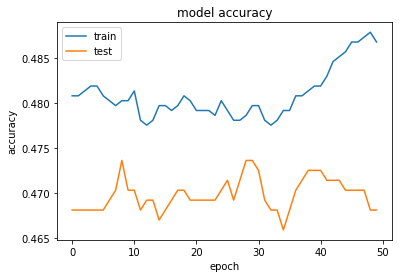

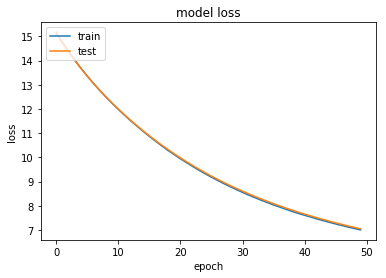

32/57 [===============>..............] - ETA: 0s[12.274268300909744, 0.49122806546980874]


In [4]:
import numpy as np
import keras

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
# To split data stuff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import regularizers

OUTPUT = 3

np_feat_arr = np.array(normal_feature_array)
np_label_arr = to_categorical(normal_label_array, OUTPUT)

# Do a split
X_train, X_test, y_train, y_test = train_test_split(np_feat_arr, 
                                                    np_label_arr, 
                                                    test_size=0.02, 
                                                    random_state=46)

model = Sequential()
model.add(Dense(units=len(XKey), 
                input_dim=len(XKey),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(Dense(units=16))
model.add(Activation('relu'))
model.add(Dense(units=64))
model.add(Activation('relu'))
model.add(Dense(units=12))
model.add(Activation('relu'))
model.add(Dense(units=OUTPUT))
model.add(Activation('softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.00001),
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, validation_split=0.33, 
                    epochs=50, batch_size=16, verbose=1)
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)

print(loss_and_metrics)
